# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.

🤝 BREAKOUT ROOM #1:
  - Task 1: Depends and Set-Up
  - Task 2: Setting up RAG With Production in Mind
  - Task 3: RAG LCEL Chain



## Task 1: Depends and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [6]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.9/258.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 27.1 MB/s eta 0:00:00


We'll need an OpenAI API Key:

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


And the LangSmith set-up:

In [4]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Session 16 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


Let's verify our project so we can leverage it in LangSmith later.

In [8]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Session 16 - c697f778


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

⚠ If you're running in a non-Chrome browser - you may run into issues with this cell. Please upload the file using Colab's file upload - and indicate the `file_path` in the cell with `file_path`. ⚠

![image](https://i.imgur.com/Qa1Uwlj.png)



> NOTE: You can skip this step if you are running locally - please just point to your local file.

In [9]:
from google.colab import files
uploaded = files.upload()

Saving DeekSeek-R1.pdf to DeekSeek-R1.pdf


In [10]:
file_path = list(uploaded.keys())[0]
file_path

'DeekSeek-R1.pdf'

We'll define our chunking strategy.

In [11]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [12]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

In [13]:
len(docs)

73

In [14]:
len(documents)

22

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [15]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings
import time

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)

start_time = time.perf_counter()
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})
end_time = time.perf_counter()
duration = end_time - start_time
print(f"Time taken to add documents: {duration:.2f} seconds")

Time taken to add documents: 2.03 seconds


##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

Limitation

Memory Constraints:

1. The in-memory QDrant client (:memory:) means all vector data is stored in RAM, which can be problematic for large document collections.
If the application restarts, all in-memory data is lost.

2. Cache Invalidation Challenges:
There's no built-in mechanism to invalidate or refresh cached embeddings when the underlying text changes.
Stale embeddings could lead to outdated or incorrect retrieval results.

3. Storage Requirements:
The local file store (./cache/) will grow as more unique text chunks are embedded, potentially consuming significant disk space over time.


Most useful:
Repeated Processing of the Same Documents

Less useful:
Highly Dynamic Content



##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [16]:
start_time = time.perf_counter()
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})
end_time = time.perf_counter()
duration = end_time - start_time
print(f"Time taken to add documents: {duration:.2f} seconds")

Time taken to add documents: 0.07 seconds


### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [17]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [18]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [24]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

Limitations:

*   No persistence between sessions, requiring rebuilding the cache from scratch each time.
*   As the cache grows with more unique prompts and responses, it can consume significant RAM

Most Useful:
*   In development & testing, and demo applications, improves responsiveness for demonstration purposes with predictable queries.

Less Useful:
*   Highly Dynamic Information Needs








##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [ ]:
### YOUR CODE HERE

## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [25]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [26]:
start_time = time.perf_counter()
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})
end_time = time.perf_counter()
duration = end_time - start_time
print(f"Time taken to add documents: {duration:.2f} seconds")

Time taken to add documents: 9.94 seconds


In [27]:
start_time = time.perf_counter()
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})
end_time = time.perf_counter()
duration = end_time - start_time
print(f"Time taken to add documents: {duration:.2f} seconds")

Time taken to add documents: 0.47 seconds


##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

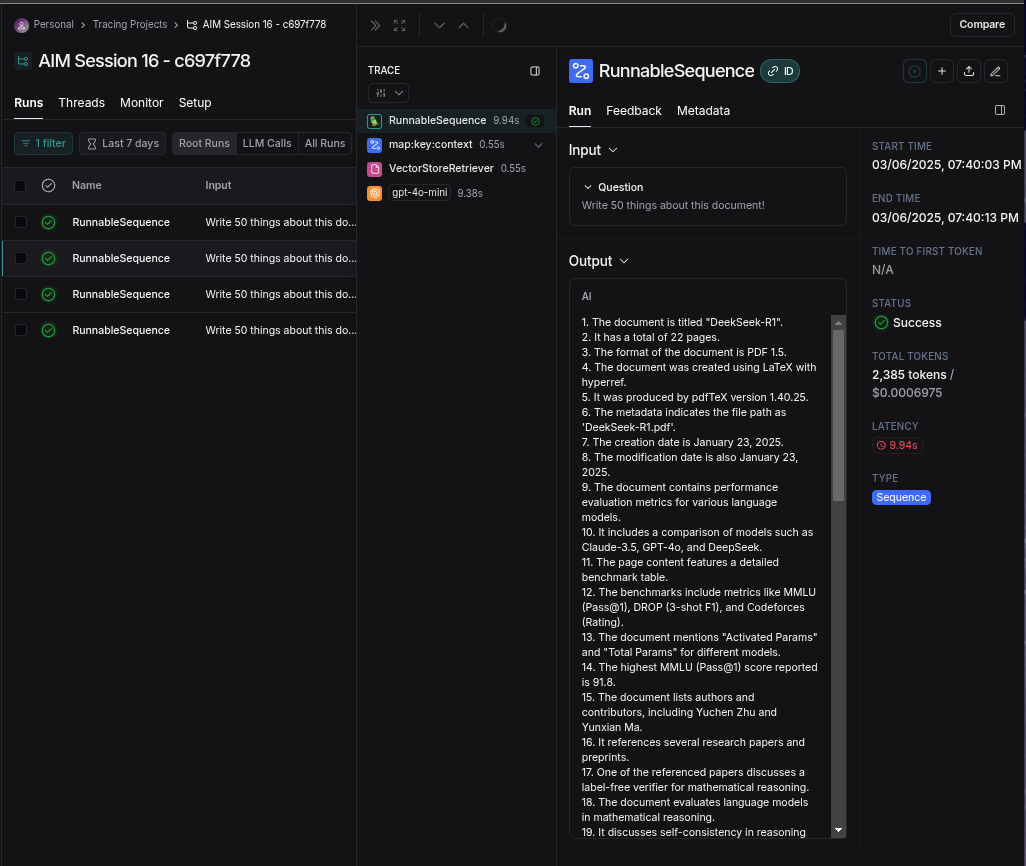

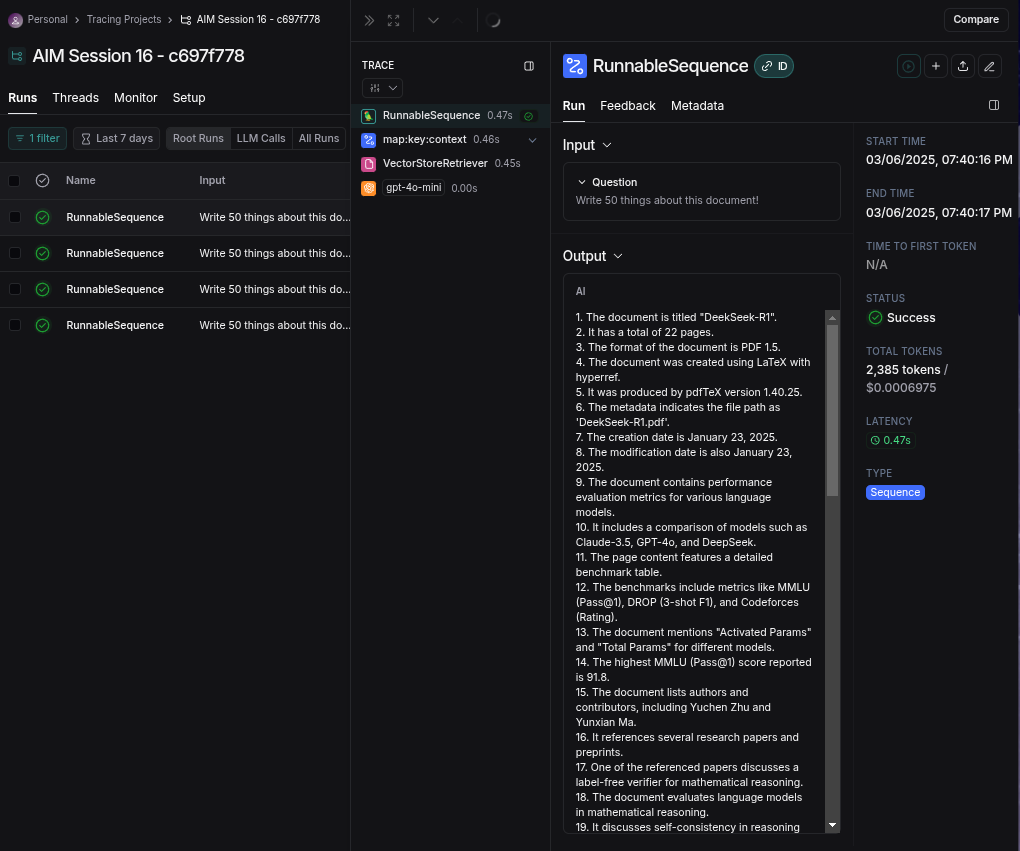

### LangGraph Studio Application

#### Snapshot

![LangGraph Studio](./LangGraphStudio.png)

#### Report 

# LLM Model Evaluation for Accuracy and Quality

Evaluating Large Language Models (LLMs) for accuracy and quality is crucial in ensuring their reliability and effectiveness in real-world applications. As these models are increasingly integrated into various domains, from customer service to content generation, understanding their performance becomes essential. This report delves into the key metrics, benchmark datasets, and challenges associated with LLM evaluation, providing a comprehensive overview of best practices to enhance model performance and mitigate biases. By systematically assessing LLMs, organizations can make informed decisions, ultimately leading to improved user experiences and trust in AI technologies.

## Conclusion/Summary

The evaluation of Large Language Models (LLMs) is a multifaceted process that requires careful consideration of various metrics, datasets, and challenges. 

| Aspect                     | Key Points                                                                 |
|---------------------------|---------------------------------------------------------------------------|
| Key Metrics               | Overlap-based (BLEU, ROUGE) and factuality-based (FACTSCORE, QAFactEval) |
| Benchmark Datasets        | MMLU, HumanEval, TruthfulQA                                               |
| Challenges                | Dataset bias, metric limitations, complexity of human evaluation          |
| Best Practices            | Diverse datasets, human evaluation, continuous monitoring                 |

To ensure the effectiveness of LLMs, it is imperative to adopt a holistic evaluation approach that combines quantitative metrics with qualitative assessments. Moving forward, organizations should prioritize ongoing evaluation and adaptation to maintain the relevance and accuracy of their models in an ever-evolving landscape.

## Key Metrics for Evaluating LLMs

**Evaluating the accuracy and quality of Large Language Models (LLMs) requires a combination of metrics that assess various aspects of their performance.** Key metrics can be categorized into overlap-based metrics and factuality-based metrics.

- **Overlap-based Metrics**: These metrics, such as BLEU and ROUGE, measure the similarity between generated text and reference text. BLEU focuses on precision by evaluating n-gram overlaps, while ROUGE emphasizes recall, making it particularly useful for summarization tasks. For instance, BLEU scores are calculated based on the fraction of words in the generated text that appear in the reference, while ROUGE assesses how much of the reference text is captured in the generated output.

- **Factuality-based Metrics**: These metrics evaluate the accuracy of the information provided by LLMs. Tools like FACTSCORE and QAFactEval assess whether generated text contains factual inaccuracies. For example, FACTSCORE breaks down generated content into atomic facts and checks their accuracy against reliable sources, ensuring that the model's outputs are not only plausible but also factually correct.

By employing these metrics, organizations can ensure a comprehensive evaluation of LLMs, leading to improved performance and reliability.

### Sources
- Evaluation metrics | Microsoft Learn: https://learn.microsoft.com/en-us/ai/playbook/technology-guidance/generative-ai/working-with-llms/evaluation/list-of-eval-metrics
- Factuality in LLMs: Key Metrics and Improvement Strategies - Turing: https://www.turing.com/resources/llm-factuality-guide
- FACTS Grounding: A new benchmark for evaluating the factuality of large language models - Google DeepMind: https://deepmind.google/discover/blog/facts-grounding-a-new-benchmark-for-evaluating-the-factuality-of-large-language-models

## Benchmark Datasets and Evaluation Tasks

**Standardized benchmark datasets are essential for evaluating the performance of Large Language Models (LLMs).** These datasets provide a uniform framework to assess various capabilities, including reasoning, language understanding, and coding tasks. Common benchmarks include MMLU, which tests general knowledge across 57 subjects, and HumanEval, which evaluates code generation abilities.

Key evaluation tasks typically involve:
- **Question Answering:** Assessing the model's ability to provide accurate responses to factual queries.
- **Commonsense Reasoning:** Evaluating how well models understand and predict everyday scenarios, as seen in benchmarks like HellaSwag.
- **Mathematical Problem Solving:** Testing the ability to solve complex math problems, exemplified by the GSM8K benchmark.

These benchmarks not only facilitate comparisons between different LLMs but also help identify areas for improvement. For instance, the TruthfulQA benchmark focuses on the accuracy of responses, particularly in avoiding misinformation, which is critical for applications in sensitive domains.

### Sources
- 20 LLM evaluation benchmarks and how they work: https://www.evidentlyai.com/llm-guide/llm-benchmarks
- LLM Benchmarks for Comprehensive Model Evaluation: https://datasciencedojo.com/blog/llm-benchmarks-for-evaluation/
- LLMs Evaluation: Benchmarks, Challenges, and Future Trends: https://blog.premai.io/llms-evaluation-benchmarks-challenges-and-future-trends

## Challenges and Best Practices in LLM Evaluation

**Evaluating large language models (LLMs) presents significant challenges that can impact the reliability of their outputs.** Key issues include dataset bias, metric limitations, and the complexity of human evaluation. Dataset bias arises when training data reflects societal biases, leading to skewed model outputs. For instance, if an LLM is trained predominantly on texts from a specific demographic, it may underperform for others.

Moreover, traditional metrics like BLEU and ROUGE may prioritize fluency over factual accuracy, potentially rewarding misleading outputs. To address these challenges, employing a combination of evaluation methods is essential. 

Best practices include:
- **Utilizing diverse evaluation datasets** to capture a wide range of scenarios and reduce bias.
- **Incorporating human evaluation** to assess nuanced aspects of model outputs, such as coherence and relevance.
- **Implementing continuous evaluation** to monitor model performance over time and adapt to new data.

By adopting these strategies, developers can enhance the robustness and fairness of LLM evaluations.

### Sources
- Evaluating Large Language Models: Techniques, Challenges, and Best Practices, March 5, 2024: https://medium.com/data-science-at-microsoft/evaluating-llm-systems-metrics-challenges-and-best-practices-664ac25be7e5
- A Systematic Survey and Critical Review on Evaluating Large Language Models: Challenges, Limitations, and Recommendations, November 2024: https://aclanthology.org/2024.emnlp-main.764/
- LLM Evaluation 101: Best Practices, Challenges & Proven Techniques, March 4, 2025: https://langfuse.com/blog/2025-03-04-llm-evaluation-101-best-practices-and-challenges

# LLM Model Evaluation for Accuracy and Quality

## Conclusion

Evaluating Large Language Models (LLMs) involves a multifaceted approach that incorporates various metrics, benchmark datasets, and best practices. Key evaluation metrics include overlap-based metrics like BLEU and ROUGE, which assess text similarity, and factuality-based metrics such as FACTSCORE, which ensure the accuracy of generated information. Standardized benchmark datasets, including MMLU and HumanEval, provide a framework for assessing model capabilities across diverse tasks.

To enhance evaluation reliability, it is crucial to address challenges such as dataset bias and metric limitations. Best practices include utilizing diverse datasets, incorporating human evaluations, and implementing continuous assessment. By following these guidelines, organizations can improve the accuracy and quality of LLM outputs, ensuring they meet the demands of real-world applications.

| Aspect                     | Key Points                                                                 |
|---------------------------|---------------------------------------------------------------------------|
| Evaluation Metrics         | Overlap-based (BLEU, ROUGE) and factuality-based (FACTSCORE) metrics     |
| Benchmark Datasets         | MMLU for general knowledge, HumanEval for code generation                 |
| Challenges                 | Dataset bias, metric limitations, complexity of human evaluation           |
| Best Practices             | Use diverse datasets, incorporate human evaluation, implement continuous evaluation | 

Next steps involve adopting these practices to refine LLM evaluations, ultimately leading to more reliable and effective models in various applications.